In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data = pd.read_csv("/content/Covid Dataset.csv")

In [8]:
data = data.loc[:, (data != data.iloc[0]).any()]

In [9]:
label_encoder = LabelEncoder()
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = label_encoder.fit_transform(data[column])

In [10]:
X = data.drop('COVID-19', axis=1)  # Assuming 'COVID-19' is the target column
y = data['COVID-19']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

In [13]:
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'K-Nearest Neighbors': {'n_neighbors': [2, 3, 5, 7, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
}

In [14]:
best_estimators = {}
for model_name, model in models.items():
    print(f"Training and tuning {model_name}")
    grid_search = GridSearchCV(model, param_grids[model_name], scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_

Training and tuning Logistic Regression...
Training and tuning K-Nearest Neighbors...
Training and tuning Random Forest...


In [15]:
for model_name, model in best_estimators.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if model_name != 'K-Nearest Neighbors' else 'N/A'
    print(f"Accuracy: {accuracy:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"ROC AUC Score: {roc}")
    print(classification_report(y_test, y_pred))


Evaluating Logistic Regression...
Accuracy: 0.9733
MSE: 0.0267
ROC AUC Score: 0.992830952009451
              precision    recall  f1-score   support

           0       0.97      0.88      0.93       203
           1       0.97      0.99      0.98       884

    accuracy                           0.97      1087
   macro avg       0.97      0.94      0.95      1087
weighted avg       0.97      0.97      0.97      1087


Evaluating K-Nearest Neighbors...
Accuracy: 0.9770
MSE: 0.0230
ROC AUC Score: N/A
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       203
           1       1.00      0.97      0.99       884

    accuracy                           0.98      1087
   macro avg       0.95      0.99      0.96      1087
weighted avg       0.98      0.98      0.98      1087


Evaluating Random Forest...
Accuracy: 0.9844
MSE: 0.0156
ROC AUC Score: 0.9984146178365246
              precision    recall  f1-score   support

           0       

In [16]:
results = pd.DataFrame({
    "Model": list(best_estimators.keys()),
    "Accuracy": [accuracy_score(y_test, model.predict(X_test)) for model in best_estimators.values()],
    "MSE": [mean_squared_error(y_test, model.predict(X_test)) for model in best_estimators.values()],
    "ROC AUC": [roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if model_name != 'K-Nearest Neighbors' else 'N/A' for model_name, model in best_estimators.items()]
})

In [17]:
print("\nResults Summary:")
print(results)


Results Summary:
                 Model  Accuracy       MSE   ROC AUC
0  Logistic Regression  0.973321  0.026679  0.992831
1  K-Nearest Neighbors  0.977001  0.022999       N/A
2        Random Forest  0.984361  0.015639  0.998415


In [18]:
best_model = results.loc[results['Accuracy'].idxmax(), 'Model']
print(f"\nBest model based on accuracy is: {best_model}")


Best model based on accuracy is: Random Forest


<ipython-input-20-5551ac1dac6f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results, palette="viridis")


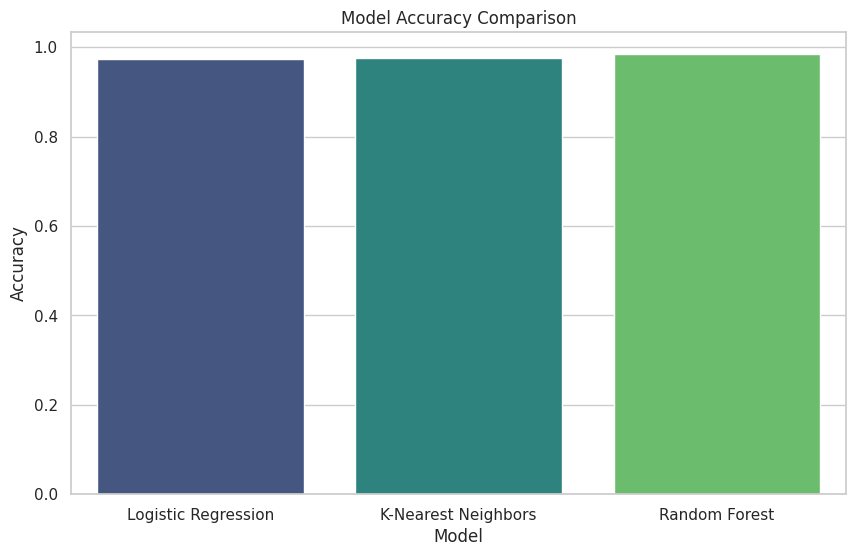

In [20]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=results, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

<ipython-input-21-6fddbb196ab3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="MSE", data=results, palette="inferno")


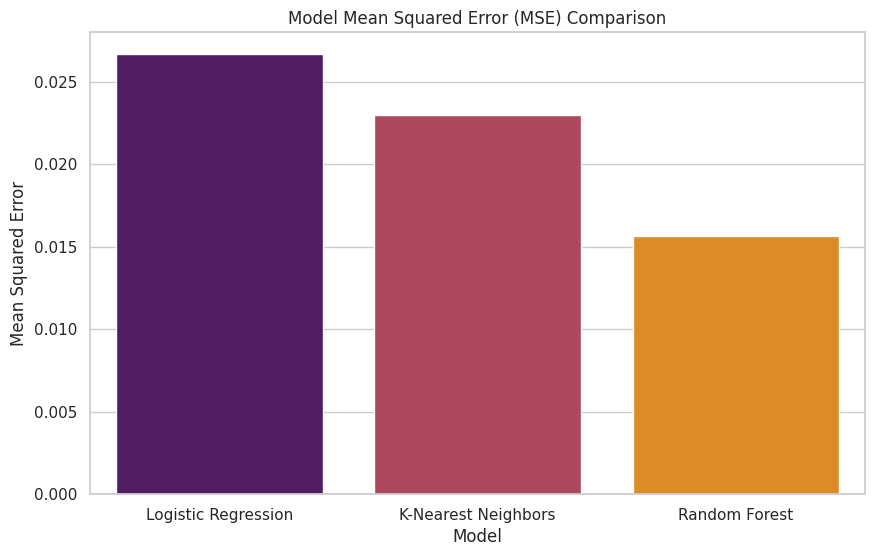

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="MSE", data=results, palette="inferno")
plt.title("Model Mean Squared Error (MSE) Comparison")
plt.ylabel("Mean Squared Error")
plt.show()

<ipython-input-24-7af890eeb588>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="ROC AUC", data=results.dropna(subset=["ROC AUC"]), palette="magma")


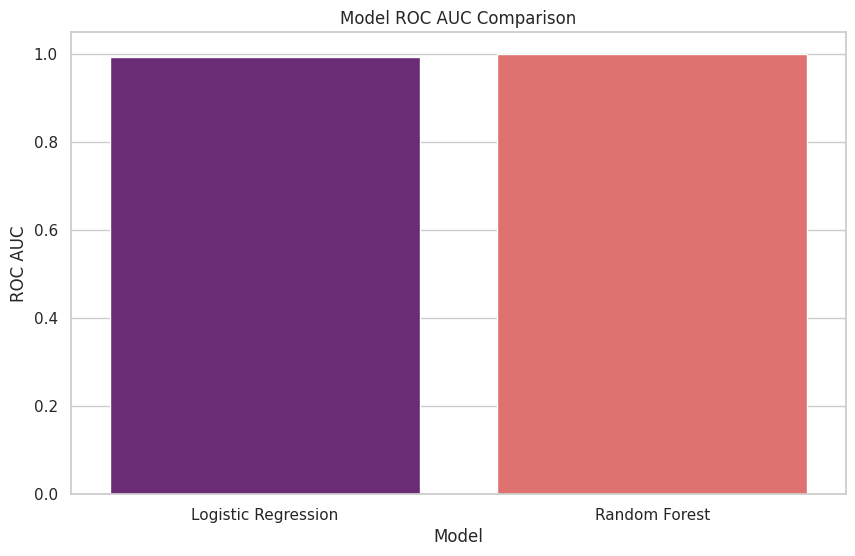

In [24]:
plt.figure(figsize=(10, 6))
# Convert 'ROC AUC' to numeric, replacing non-numeric values with NaN
results['ROC AUC'] = pd.to_numeric(results['ROC AUC'], errors='coerce')
# Drop rows with NaN values in 'ROC AUC' after conversion
sns.barplot(x="Model", y="ROC AUC", data=results.dropna(subset=["ROC AUC"]), palette="magma")
plt.title("Model ROC AUC Comparison")
plt.ylabel("ROC AUC")
plt.show()

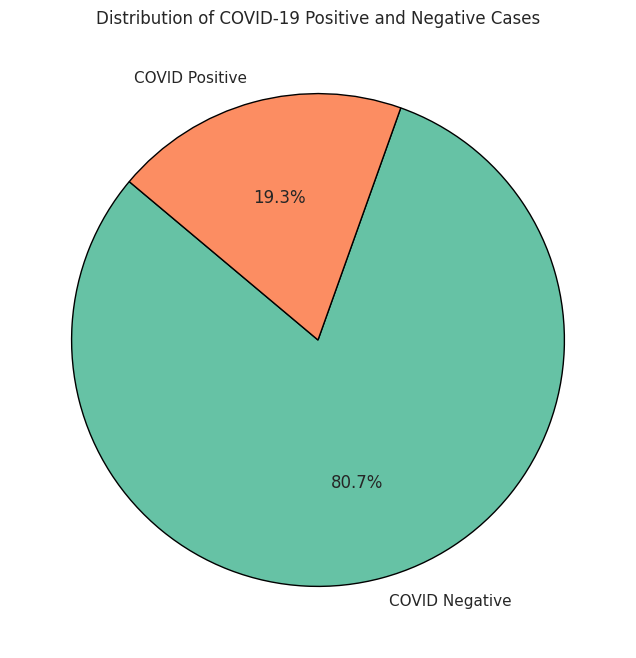

In [25]:
covid_counts = data['COVID-19'].value_counts()
labels = ['COVID Negative', 'COVID Positive']
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(8, 8))
plt.pie(covid_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of COVID-19 Positive and Negative Cases")
plt.show()

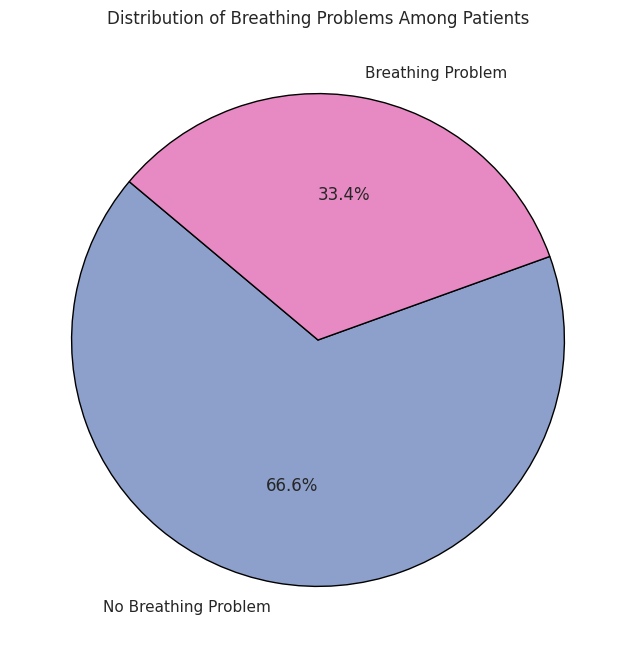

In [26]:
if 'Breathing Problem' in data.columns:
    symptom_counts = data['Breathing Problem'].value_counts()
    labels = ['No Breathing Problem', 'Breathing Problem']
    colors = ['#8da0cb', '#e78ac3']

    plt.figure(figsize=(8, 8))
    plt.pie(symptom_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
    plt.title("Distribution of Breathing Problems Among Patients")
    plt.show()

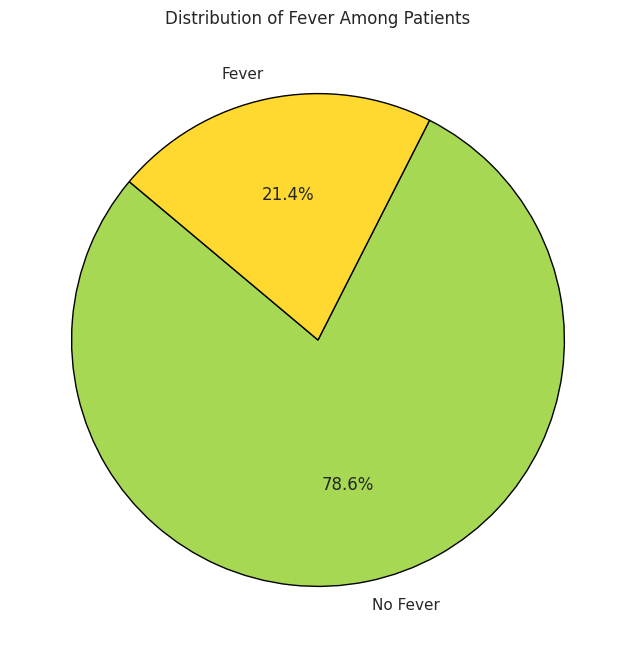

In [27]:
if 'Fever' in data.columns:
    fever_counts = data['Fever'].value_counts()
    labels = ['No Fever', 'Fever']
    colors = ['#a6d854', '#ffd92f']

    plt.figure(figsize=(8, 8))
    plt.pie(fever_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
    plt.title("Distribution of Fever Among Patients")
    plt.show()